# Longitudinal Length

In [1]:
from pathlib import Path
# from project_heart.lv import LV
from project_heart.utils import set_jupyter_backend
from project_heart.enums import *
set_jupyter_backend("pythreejs")
import logging
import numpy as np
float_formatter = "{:.5f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

from project_heart.examples import get_lv_ideal
from project_heart.examples import get_lv_typeA

lv_ideal = get_lv_ideal(Path("../../_static/sample_files/ideal_linear_pressure_increase copy.xplt"))
lv_typeA = get_lv_typeA(
    Path("../../_static/sample_files/lv_typeA_hex.vtk"),
    Path("../../_static/sample_files/sample_displacement_lv_typeA_hex_states_linear_press_incr.pbz2")
    )

sample_spk_typeA_endo = lv_typeA.get_speckles(spk_name="SAMPLE", spk_group="endo", spk_collection="SAMPLE")[0]
sample_spk_typeA_epi = lv_typeA.get_speckles(spk_name="SAMPLE", spk_group="epi", spk_collection="SAMPLE")[0]

## Longitudinal Length

**Definition**: Curvature length from a set of points roughtly alinged in a plane normal to longitudinal axis.

The longitudinal length is computed as the length of a curve inscribed within a region of the myocardium along the longitudinal axis. In our implementation, we created these curves based on specified speckles, therefore, we are essentially computing the "speckle length". It is important to note that the normal of the plane of reference for these speckles must be perpendicular to the longitudinal axis to ensure this metric is aligned with its definition. 

Here is an example:

In [2]:
sample_spk_ideal = lv_ideal.get_speckles(spk_name="SAMPLE-LONG", spk_group="epi", spk_collection="SAMPLE")

In [3]:
lv_ideal.plot_speckles(sample_spk_ideal[0], 
                       cmap="tab20", 
                        point_size=200,
                       add_k_centers=True, 
                       k_centers_as_line=True, 
                       k_bins=True,
                       t=0.0)

Renderer(camera=PerspectiveCamera(aspect=1.5, children=(DirectionalLight(color='#fefefe', position=(49999.9999…

As speckles are pre-defined during initialization, their corresponing mesh ids are fixed, which allows us to 'draw' a line between clusters inside a speckle and track their deformation throughout timesteps. 

In [4]:
lv_ideal.plot_speckles(sample_spk_ideal[0], 
                       cmap="tab20", 
                        point_size=200,
                       add_k_centers=True, 
                       k_centers_as_line=True, 
                       k_bins=True,
                       t=0.5)

Renderer(camera=PerspectiveCamera(aspect=1.5, children=(DirectionalLight(color='#fefefe', position=(49999.9999…

TODO: Continue explanation

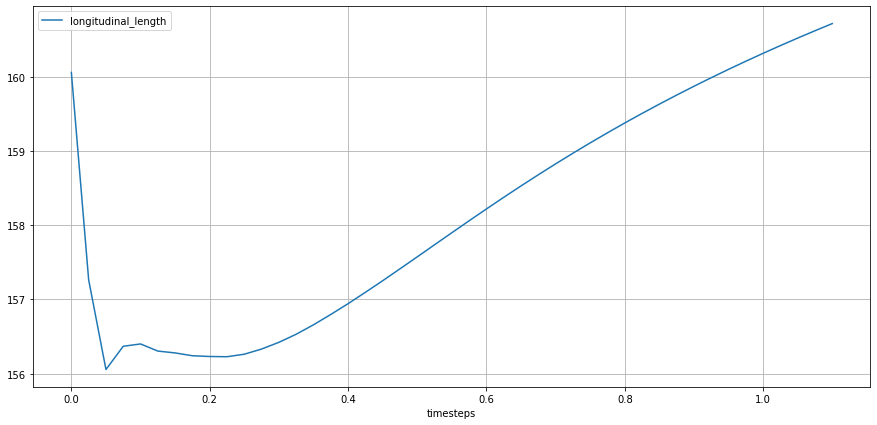

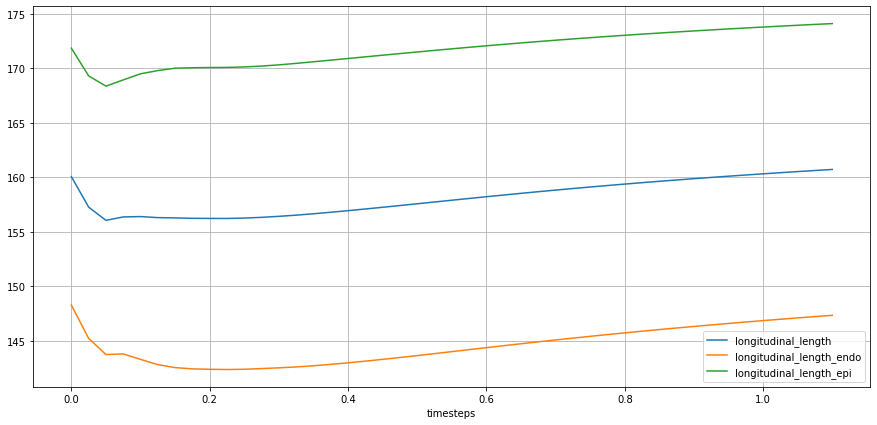

In [5]:
long_spks = lv_typeA.get_speckles(spk_collection="long-6")
lv_typeA.longitudinal_length(
    long_spks, 
    approach="k_ids", 
    recompute=True,
    reduce_by={"group"},
    log_level=logging.WARN,
    )
lv_typeA.plot_metric(lv_typeA.STATES.LONG_LENGTH, 
    from_ts=0.0,
    plot_infos=["group"],
    )

In our approach, the final computation of 'longitudinal length' is the result of the reduction of the sum of the reduced values of individual groups formed by 'group' and 'name', which essentially composes the target line for the given geometric metric. 

For instance, this is a sample group formed by speckles' 'group' and 'name' values:

In [6]:
sample_spk_ideal = lv_ideal.get_speckles(spk_name="SAMPLE-LONG", spk_group="epi", spk_collection="SAMPLE")
lv_ideal.plot_speckles(sample_spk_ideal, 
                       cmap="tab20", 
                        point_size=200,
                       add_k_centers=True, 
                       k_centers_as_line=True, 
                       k_bins=False,
                       t=0)

Renderer(camera=PerspectiveCamera(aspect=1.5, children=(DirectionalLight(color='#fefefe', position=(49999.9999…

At the end, the final result is the reduction of the length of each of these groups:

In [7]:
sample_spk_ideal = lv_ideal.get_speckles(spk_collection="long-6")
lv_ideal.plot_speckles(sample_spk_ideal, 
                       cmap="jet", 
                        point_size=200,
                       add_k_centers=False, 
                       k_centers_as_line=False, 
                       k_bins=False,
                       t=0)

Renderer(camera=PerspectiveCamera(aspect=1.5, children=(DirectionalLight(color='#fefefe', position=(49999.9999…

However, considering that these lines are not fully connected, distorsions might occur at points of discontinuities and the full length of the desired line might not be achieved (depending on number of clusters and mesh size). Therefore, to account for possible errors, we define the 'global longitudinal length' separately. 


Nonetheless, the described approach can be used to compute local longitudinal lengths by reducing subset values. Note that, by default, subsets are created and named continously, which might result in mutiple subset names for similar regions; therefore, we can 'merge' their result and apply a single reduction over multiple subsets.

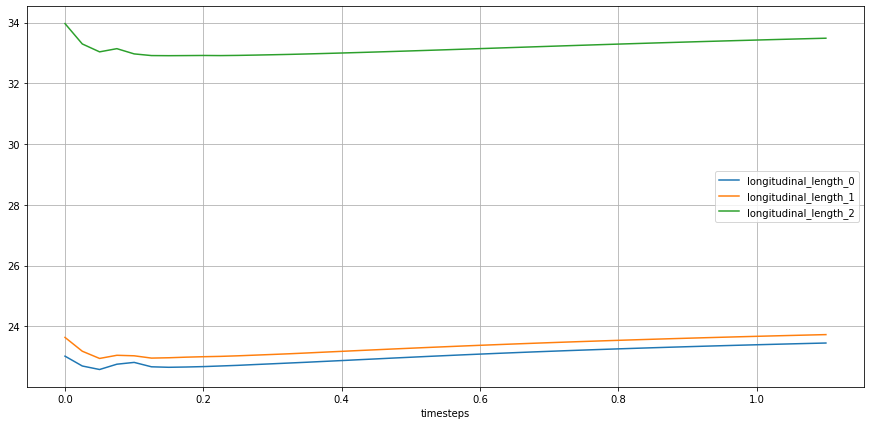

In [8]:
long_spks = lv_typeA.get_speckles(spk_collection="long-6")
lv_typeA.longitudinal_length(
    long_spks, 
    approach="k_ids", 
    recompute=True,
    reduce_by={"subset"},
    merge_subset={
        5: 0, 
        4: 1, 
        3: 2
        },
    log_level=logging.WARN,
    )
lv_typeA.plot_metric(lv_typeA.STATES.LONG_LENGTH, 
    from_ts=0.0,
    plot_infos={"subset"},
    plot_infos_only=True,
    plot_infos_only_on_info_plots=True
    )

TODO: 

* add reduction by subset and group (will result in same similar graph but with individual values for endo-epi) 
* add option to save 'longitudinal length' as the reduction of subsets, instead of sum (might be useful for detailed explanations)

## Global longitudinal length:

As previously explained, discontinuities between cluster centers within speckle subsets might lead to errors when computing the overall length of the desired curve. Although this error is reduced with finer meshes and increase number of clusters within speckles, we considered the concept of "global longitudinal speckle" as a separated method for clarity purposes. 

The global longitudinal length is defined as the length over an entire speckle and it is intended to be used with speckles that do not contain subsets. Essentially, we apply the previously described method for length computation over a single speckle that covers the entire region of interest. The final result is the reduction of all selected speckles. See example below:

In [9]:
sample_spk_typeA = lv_typeA.get_speckles(spk_name="0.0", spk_group="epi", spk_collection="long-1")
lv_typeA.plot_speckles(sample_spk_typeA, 
                       cmap="hot", 
                        point_size=200,
                        add_k_centers=True, 
                        # k_centers_as_line=True, 
                        k_bins=True,
                            #    k_center_filters=dict(
                            #    mfilter_ws=5, 
                            #    sfilter_ws=9, 
                            #    sfilter_or=1, 
                            #    keep_first=False, 
                            #    keep_last=False)
                        )

Renderer(camera=PerspectiveCamera(aspect=1.5, children=(DirectionalLight(color='#fefefe', position=(49999.9999…

The final metric is shown below:

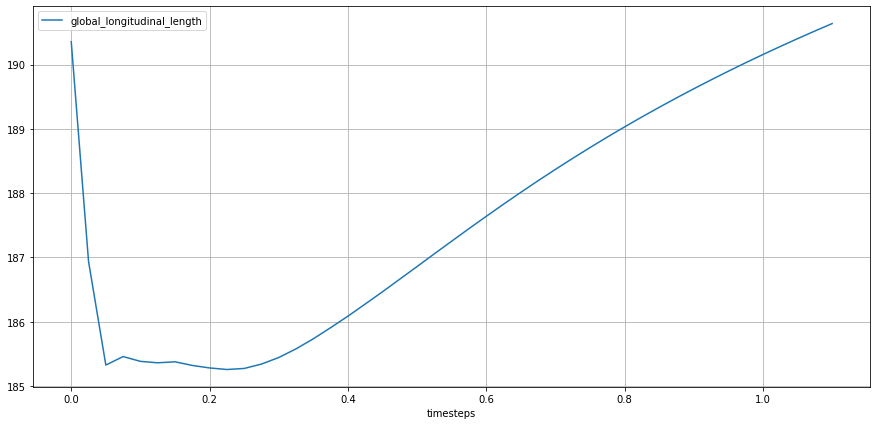

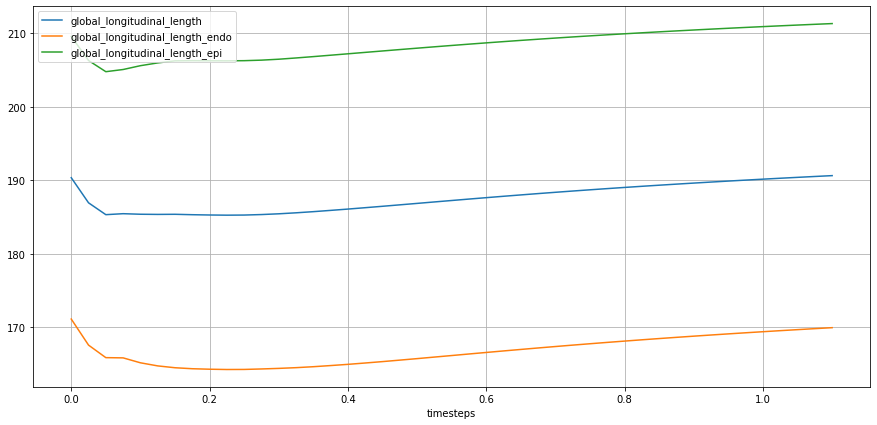

In [10]:
long_spks = lv_typeA.get_speckles(spk_collection="long-1")
lv_typeA.global_longitudinal_length(
    long_spks, 
    approach="k_ids", 
    recompute=True,
    reduce_by={"group"},
    log_level=logging.WARN,
    # line_seg_filter_kwargs=dict(
    #                        mfilter_ws=3, 
    #                        sfilter_ws=9, 
    #                        sfilter_or=1, 
    #                        keep_first=True, 
    #                        keep_last=True) 
    )
lv_typeA.plot_metric(lv_typeA.STATES.GLOBAL_LONGITUDINAL_LENGTH, 
    from_ts=0.0,
    plot_infos=["group"])

Although the computation of local speckles is helpful for detailed information about the myocardium, it is not often used in a clinical setting as values may vary from different vendors and different computation approaches. A recommended standard practice is to report values at Endocardium.